In [26]:
import torch
import torch.optim as optim

import numpy as np
import pandas as pd
import pickle
import os
from utils.vmf_batch import vMF

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.training_utils import train, evaluate

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
with open('./data/Farrow_data/iterator/soma_centered/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/Farrow_data/iterator/soma_centered/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
   

In [6]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

 
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [5]:
np.unique(train_iterator.dataset.labels[train_iterator.sampler.indices])

array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13])

### load model

In [7]:
emb_dim = 32
latent_dim = 32
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01

enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 45.709938049316406


In [8]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL

In [33]:
torch.cuda.empty_cache()

In [34]:

N_EPOCHS= 50
save_path_model= './models/Farrow/finetuned/soma_centered/finetuned_scaled_vae_frac%.1f_best_run%i.pt'
save_path_losses = './models/Farrow/finetuned/soma_centered/finetuned_scaled_losses_frac%.1f_run%i.npy'
save_path_elapsed_time = './models/Farrow/finetuned/soma_centered/finetuned_scaled_elapsed_time_frac%.1f_run%i.npy'
# state_dict = torch.load('./models/5_populations/emb32_hid32_lat32_dp0.1_k500_max_frac1.0_scaled_sum_run1_best.pt')

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for frac in [1., .9, .5, .1, 0.]:
    
  
    runs = range(1,4)
        
    for run in runs:
        
        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
        
        if os.path.exists(save_path_model%(frac,run)):
            state_dict = torch.load(save_path_model%(frac,run))
            
            # load model
            model.load_state_dict(state_dict['model_state_dict'])
            
            # overwrite optimizer if the model had been trained already
            optimizer.load_state_dict(state_dict['optimizer_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            losses = np.load(save_path_losses%(frac, run))
            elapsed_time = np.load(save_path_elapsed_time%(frac, run))
            
            last_epoch = state_dict['epoch']
            training = list(losses[:last_epoch,:2])
            validation = list(losses[:last_epoch,2:])
            elapsed_time = elapsed_time[:last_epoch]
            elapsed_time = np.hstack((elapsed_time, np.zeros((N_EPOCHS))))
            best_test_loss = losses[:,2].min()
            
        else:
            # load pre-trained model
            state_dict = torch.load('./models/Farrow/scratch/soma_centered/vae_frac0.0_scaled_best_run%i.pt'%run)
            # the first run was the best
            model.load_state_dict(state_dict['model_state_dict'])
            classifier.apply(init_weights)
            best_test_loss = np.infty

            losses = np.load('./models/Farrow/scratch/soma_centered/losses_frac0.0_scaled_run%i.npy'%run)
            elapsed_time = np.load('./models/Farrow/scratch/soma_centered/elapsed_time_frac0.0_scaled_run%i.npy'%run)
            last_epoch = len(elapsed_time)
            elapsed_time = np.hstack((elapsed_time, np.zeros((N_EPOCHS))))
            training = list(losses[:,:2])
            validation = list(losses[:,2:])
        
        
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')


        
        
        for e in range(N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val
            
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e+last_epoch] = start.elapsed_time(end) # milliseconds
            
            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Time elapsed [s]: {elapsed_time[e]/1000:.2f}')


            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e + last_epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification loss 
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(frac, run),losses)
                np.save(save_path_elapsed_time%(frac,run),elapsed_time)
        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(frac, run), losses)
        np.save(save_path_elapsed_time%(frac,run),elapsed_time)

Epoch 0, Train Loss: 66.38, Val Loss: 347.67, Time elapsed [s]: 30.63
Epoch 1, Train Loss: 66.06, Val Loss: 358.56, Time elapsed [s]: 30.08
Epoch 2, Train Loss: 67.52, Val Loss: 353.34, Time elapsed [s]: 27.68
Epoch 3, Train Loss: 67.41, Val Loss: 348.22, Time elapsed [s]: 28.83
Epoch 4, Train Loss: 66.77, Val Loss: 351.59, Time elapsed [s]: 28.17
Epoch 5, Train Loss: 64.86, Val Loss: 346.78, Time elapsed [s]: 27.72
Epoch 6, Train Loss: 65.28, Val Loss: 350.25, Time elapsed [s]: 27.81
Epoch 7, Train Loss: 65.94, Val Loss: 356.68, Time elapsed [s]: 29.04
Epoch 8, Train Loss: 66.53, Val Loss: 355.86, Time elapsed [s]: 28.55
Epoch 9, Train Loss: 65.22, Val Loss: 360.28, Time elapsed [s]: 27.86
Epoch 10, Train Loss: 65.11, Val Loss: 356.75, Time elapsed [s]: 28.03
Epoch 11, Train Loss: 65.73, Val Loss: 344.46, Time elapsed [s]: 28.32
Epoch 12, Train Loss: 63.38, Val Loss: 348.33, Time elapsed [s]: 28.10
Epoch 13, Train Loss: 65.68, Val Loss: 361.25, Time elapsed [s]: 27.22
Epoch 14, Train 

Epoch 16, Train Loss: 70.27, Val Loss: 361.84, Time elapsed [s]: 27.14
Epoch 17, Train Loss: 70.33, Val Loss: 365.05, Time elapsed [s]: 27.58
Epoch 18, Train Loss: 70.68, Val Loss: 376.38, Time elapsed [s]: 27.36
Epoch 19, Train Loss: 69.21, Val Loss: 359.93, Time elapsed [s]: 27.32
Epoch 20, Train Loss: 69.86, Val Loss: 360.38, Time elapsed [s]: 27.30
Epoch 21, Train Loss: 69.66, Val Loss: 381.84, Time elapsed [s]: 27.35
Epoch 22, Train Loss: 69.11, Val Loss: 360.03, Time elapsed [s]: 27.86
Epoch 23, Train Loss: 69.27, Val Loss: 360.67, Time elapsed [s]: 28.10
Epoch 24, Train Loss: 67.13, Val Loss: 364.45, Time elapsed [s]: 27.30
Epoch 25, Train Loss: 69.12, Val Loss: 347.23, Time elapsed [s]: 27.25
Epoch 26, Train Loss: 68.94, Val Loss: 368.30, Time elapsed [s]: 27.54
Epoch 27, Train Loss: 66.38, Val Loss: 364.29, Time elapsed [s]: 27.41
Epoch 28, Train Loss: 67.05, Val Loss: 360.25, Time elapsed [s]: 27.10
Epoch 29, Train Loss: 64.74, Val Loss: 373.57, Time elapsed [s]: 27.21
Epoch 

Epoch 32, Train Loss: 59.37, Val Loss: 361.61, Time elapsed [s]: 26.98
Epoch 33, Train Loss: 58.58, Val Loss: 365.70, Time elapsed [s]: 27.10
Epoch 34, Train Loss: 56.13, Val Loss: 352.72, Time elapsed [s]: 27.25
Epoch 35, Train Loss: 55.97, Val Loss: 378.07, Time elapsed [s]: 27.78
Epoch 36, Train Loss: 58.44, Val Loss: 381.28, Time elapsed [s]: 27.65
Epoch 37, Train Loss: 57.95, Val Loss: 389.20, Time elapsed [s]: 27.97
Epoch 38, Train Loss: 57.41, Val Loss: 381.92, Time elapsed [s]: 28.07
Epoch 39, Train Loss: 56.80, Val Loss: 372.65, Time elapsed [s]: 27.07
Epoch 40, Train Loss: 56.14, Val Loss: 385.80, Time elapsed [s]: 27.08
Epoch 41, Train Loss: 58.84, Val Loss: 365.11, Time elapsed [s]: 26.96
Epoch 42, Train Loss: 58.60, Val Loss: 361.29, Time elapsed [s]: 27.54
Epoch 43, Train Loss: 59.55, Val Loss: 376.22, Time elapsed [s]: 27.33
Epoch 44, Train Loss: 57.29, Val Loss: 377.79, Time elapsed [s]: 27.32
Epoch 45, Train Loss: 56.19, Val Loss: 365.51, Time elapsed [s]: 27.32
Epoch 

Epoch 48, Train Loss: 45.44, Val Loss: 347.04, Time elapsed [s]: 27.32
Epoch 49, Train Loss: 43.09, Val Loss: 375.26, Time elapsed [s]: 27.76
Epoch 0, Train Loss: 47.71, Val Loss: 367.17, Time elapsed [s]: 28.04
Epoch 1, Train Loss: 49.58, Val Loss: 377.67, Time elapsed [s]: 28.16
Epoch 2, Train Loss: 49.60, Val Loss: 355.90, Time elapsed [s]: 27.19
Epoch 3, Train Loss: 48.98, Val Loss: 362.25, Time elapsed [s]: 27.23
Epoch 4, Train Loss: 49.19, Val Loss: 355.11, Time elapsed [s]: 27.36
Epoch 5, Train Loss: 45.77, Val Loss: 370.36, Time elapsed [s]: 27.34
Epoch 6, Train Loss: 48.63, Val Loss: 363.93, Time elapsed [s]: 27.15
Epoch 7, Train Loss: 46.85, Val Loss: 369.92, Time elapsed [s]: 27.20
Epoch 8, Train Loss: 47.97, Val Loss: 360.07, Time elapsed [s]: 27.52
Epoch 9, Train Loss: 48.40, Val Loss: 368.01, Time elapsed [s]: 27.16
Epoch 10, Train Loss: 48.42, Val Loss: 383.61, Time elapsed [s]: 27.10
Epoch 11, Train Loss: 48.76, Val Loss: 367.54, Time elapsed [s]: 27.48
Epoch 12, Train 

Epoch 14, Train Loss: 24.36, Val Loss: 439.86, Time elapsed [s]: 27.61
Epoch 15, Train Loss: 24.28, Val Loss: 433.64, Time elapsed [s]: 27.36
Epoch 16, Train Loss: 24.12, Val Loss: 445.24, Time elapsed [s]: 27.86
Epoch 17, Train Loss: 23.92, Val Loss: 451.12, Time elapsed [s]: 28.26
Epoch 18, Train Loss: 21.76, Val Loss: 439.82, Time elapsed [s]: 27.70
Epoch 19, Train Loss: 22.13, Val Loss: 448.01, Time elapsed [s]: 28.02
Epoch 20, Train Loss: 23.95, Val Loss: 437.54, Time elapsed [s]: 27.62
Epoch 21, Train Loss: 24.94, Val Loss: 455.32, Time elapsed [s]: 27.46
Epoch 22, Train Loss: 25.01, Val Loss: 436.96, Time elapsed [s]: 27.95
Epoch 23, Train Loss: 21.33, Val Loss: 440.97, Time elapsed [s]: 27.39
Epoch 24, Train Loss: 23.66, Val Loss: 431.88, Time elapsed [s]: 27.69
Epoch 25, Train Loss: 22.77, Val Loss: 431.86, Time elapsed [s]: 27.92
Epoch 26, Train Loss: 22.34, Val Loss: 421.27, Time elapsed [s]: 27.31
Epoch 27, Train Loss: 23.68, Val Loss: 440.67, Time elapsed [s]: 27.28
Epoch 

Epoch 30, Train Loss: 28.25, Val Loss: 429.39, Time elapsed [s]: 27.58
Epoch 31, Train Loss: 27.96, Val Loss: 452.70, Time elapsed [s]: 27.22
Epoch 32, Train Loss: 27.97, Val Loss: 416.07, Time elapsed [s]: 27.36
Epoch 33, Train Loss: 24.12, Val Loss: 424.64, Time elapsed [s]: 27.33
Epoch 34, Train Loss: 25.55, Val Loss: 427.47, Time elapsed [s]: 27.23
Epoch 35, Train Loss: 27.21, Val Loss: 428.84, Time elapsed [s]: 27.50
Epoch 36, Train Loss: 24.19, Val Loss: 431.67, Time elapsed [s]: 27.60
Epoch 37, Train Loss: 24.47, Val Loss: 430.22, Time elapsed [s]: 27.27
Epoch 38, Train Loss: 24.12, Val Loss: 432.87, Time elapsed [s]: 27.07
Epoch 39, Train Loss: 23.55, Val Loss: 434.66, Time elapsed [s]: 27.21
Epoch 40, Train Loss: 23.75, Val Loss: 444.39, Time elapsed [s]: 27.19
Epoch 41, Train Loss: 24.04, Val Loss: 437.81, Time elapsed [s]: 27.31
Epoch 42, Train Loss: 25.80, Val Loss: 427.67, Time elapsed [s]: 28.42
Epoch 43, Train Loss: 23.37, Val Loss: 433.21, Time elapsed [s]: 27.20
Epoch 

Epoch 46, Train Loss: 14.77, Val Loss: 528.37, Time elapsed [s]: 27.40
Epoch 47, Train Loss: 14.60, Val Loss: 521.76, Time elapsed [s]: 27.07
Epoch 48, Train Loss: 14.29, Val Loss: 506.91, Time elapsed [s]: 27.09
Epoch 49, Train Loss: 14.47, Val Loss: 509.99, Time elapsed [s]: 27.06
Epoch 0, Train Loss: 18.50, Val Loss: 516.59, Time elapsed [s]: 27.26
Epoch 1, Train Loss: 18.39, Val Loss: 530.14, Time elapsed [s]: 27.24
Epoch 2, Train Loss: 18.03, Val Loss: 530.50, Time elapsed [s]: 27.20
Epoch 3, Train Loss: 18.72, Val Loss: 528.83, Time elapsed [s]: 27.64
Epoch 4, Train Loss: 18.41, Val Loss: 537.19, Time elapsed [s]: 27.73
Epoch 5, Train Loss: 18.79, Val Loss: 525.79, Time elapsed [s]: 27.53
Epoch 6, Train Loss: 18.27, Val Loss: 516.42, Time elapsed [s]: 27.56
Epoch 7, Train Loss: 18.61, Val Loss: 516.97, Time elapsed [s]: 27.53
Epoch 8, Train Loss: 18.05, Val Loss: 544.07, Time elapsed [s]: 27.54
Epoch 9, Train Loss: 18.52, Val Loss: 520.96, Time elapsed [s]: 27.30
Epoch 10, Train 

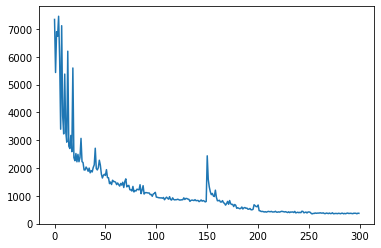

In [20]:
plt.plot(np.array(validation)[:,0])

In [23]:
elapsed_time.mean()/1000


26.72294771484375